In [43]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # Asegúrate de importar plt desde matplotlib
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import silhouette_score
import re

import warnings
warnings.filterwarnings('ignore')


The dataset contains the locations of cab ranks. In this notebook we will define the main clusters for building service stations operating in this region.

In [2]:
df=pd.read_csv("taxi_data.csv")

In [3]:
df

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank
...,...,...,...
833,27.82999,-26.24445,Zola Clinic Taxi Rank
834,27.83991,-26.24235,Zola Taxi Rank
835,27.86166,-26.23624,Zondi Taxi Rank
836,28.39097,-26.30931,kwaThema Taxi Rank


In [4]:
df.duplicated().sum()

11

# Let's eliminate the duplicates and see what to do with the nulls.

In [8]:
df=df.dropna()
df=df.drop_duplicates(subset=['NAME'])
df

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank
...,...,...,...
832,28.04441,-26.19727,Zimbabwe Taxi Rank
833,27.82999,-26.24445,Zola Clinic Taxi Rank
834,27.83991,-26.24235,Zola Taxi Rank
835,27.86166,-26.23624,Zondi Taxi Rank


# Displays geographic data geolocated on the map using the folium library.

In [18]:
import folium

In [19]:
taxtis = folium.Map(location=[0, 0], zoom_start=2, tiles="OpenStreetMap")

# Suponiendo que 'df' es tu DataFrame
for index, row in df.iterrows(): #para las filas en mi df va a ir recorriendo todas las filas
    # Agregar un círculo para cada fila del DataFrame
    folium.Circle(location=(row["LAT"], row["LON"]), radius=5, popup=row["NAME"], fill_color="yellow").add_to(pais)

# Guardar el mapa en un archivo HTML
pais

# KMeans Clustering

First, we will use the simplest clustering method which is the KMeans algorithm.



### Let's see by the elbow method which K we would be left with. 


In [13]:
# Ajustar y transformar los datos
X = df[["LON","LAT"]]



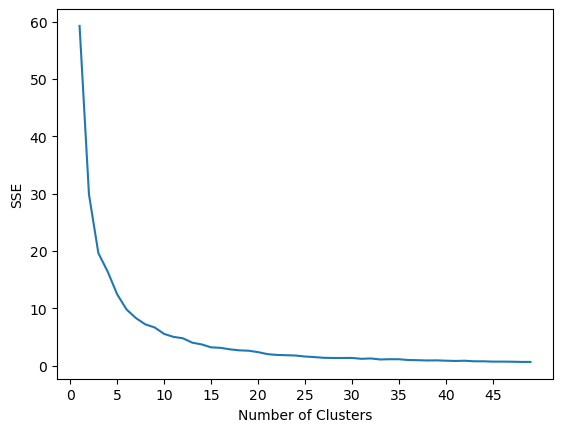

In [17]:
sse = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(X,)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 50), sse)
plt.xticks(range(1, 50))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xticks(np.arange(0, 50, 5))
plt.show()



As we can see the elbow is rotated around 10 groupings, a good method to know an exact number is using kneelocator which will give us an exact knee point for our model.

In [20]:
from kneed import KneeLocator
knee_point = KneeLocator(
    range(1, 50),
    sse,
    curve = 'convex',
    direction = 'decreasing'
)
print(knee_point.knee)

7


In [23]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
inertia_ = kmeans.inertia_
silhouette_ = silhouette_score(X, kmeans.labels_)
print("This model with 11 cluster is characterized by :")
# Iinertia is sum of squared distances of samples to their closest cluster center.
print("Iinertia : {:.3f}".format(inertia_))
print("Silhouette mean score : {:.3f}".format(silhouette_))

This model with 11 cluster is characterized by :
Iinertia : 4.830
Silhouette mean score : 0.473


Best number of clusters is 100 with a score of 0.61


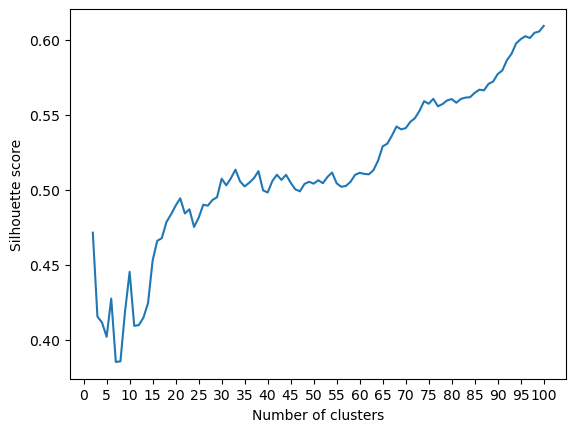

In [25]:
X = df[['LON', 'LAT']]
score = -1
scores = []
k = 0
for i in range(2, 101):
  kmeans = KMeans(n_clusters=i, random_state=3).fit(X)
  score_ = silhouette_score(X, kmeans.predict(X))
  scores.append(score_)
  if score_ > score:
    score = score_
    k=i
    
print(
'Best number of clusters is {} with a score of {:.2f}'
.format(k,score)
)
plt.plot(range(2, 101), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(0, 101, 5))
plt.show()

A score of 0.61 could be considered good, but it would not be feasible to make 100 clusters for a dataset of this size. So we will be left with 10 clusters as indicated by the elbow method.

In [ ]:
# Podemos ver que el optimo sería el 10 

In [26]:
X=df[["LON","LAT"]]


# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters = 10)

# Create pipeline: pipeline
pipeline = make_pipeline(kmeans)

# Fit the pipeline to samples
pipeline.fit(X)

pipeline.predict(X) # me asigna al cluster cada una de las filas 

X["label"]=pipeline.predict(X)


# Let's create the map

In [29]:
import folium

In [44]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan',
          'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy',
          'springgreen','midnightblue', 'red','brown','limegreen','lime',
          'pink','orchid','crimson','m']*10
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_KMeans'] = vectorizer(kmeans.labels_)
def create_map(cluster_column, colors_column, title):
    map = folium.Map(location=[X.LAT.mean(),df.LON.mean()],zoom_start=8.5)
    for _,row in df.iterrows():
        folium.CircleMarker(
            location=[row.LAT,row.LON],
            radius=5,
            popup = re.sub(r'\W+', '', row.NAME),
            fill=True,
            color=row[colors_column],
            fill_color=row[colors_column],
        ).add_to(map)

    print(title)
    return map

In [45]:
create_map('Cluster_KMeans','Colors_KMeans','KMeans Clustering')


KMeans Clustering


### DBSCAN


As we can see, the K Means algorithm does not differentiate the outliers. DBSCAN however, is a clustering algorithm, which will help us to solve the problem of geographic data with different clustering shapes and densities. 

What is the difference between one and the other?

DBSCAN allows us to exclude noise and outliers. 
We will have to define in our DBSCAN model an epsilon parameter, which defines the maximum distance between points to form a cluster.

To determine this epsilon we will use the NearestNeighbors algorithm.

According to the Scikit-Learn documentation, the "eps" parameter is a default float value of 0.5, which indicates the maximum distance between two samples to consider them neighbors to each other. This value is proportional to the expected number of neighbors, which allows us to estimate "eps" using the nearest neighbors. 




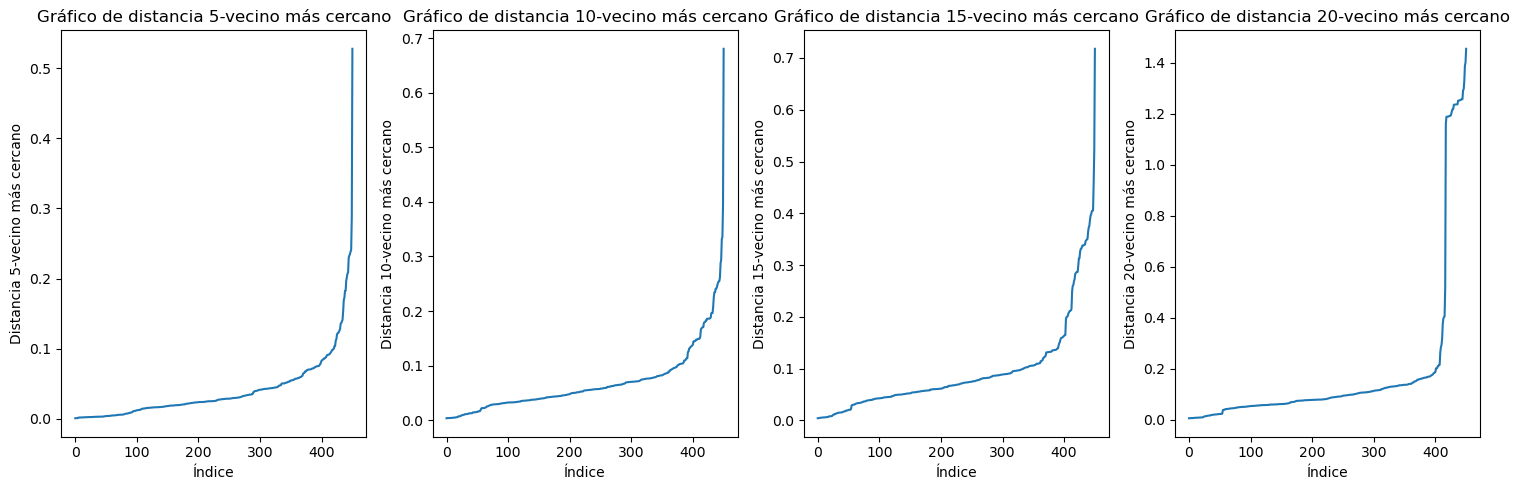

In [31]:
valores_k = [5, 10, 15,20]  

plt.figure(figsize=(15, 5))  #

for i, k in enumerate(valores_k, 1):
    plt.subplot(1, 4, i) 
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Ordena las distancias de los k-vecinos más cercanos y toma la distancia del k-ésimo vecino más cercano
    distances = np.sort(distances[:, k-1])

    # Graficar el gráfico de k-distancias
    plt.plot(np.arange(len(X)), distances)
    plt.xlabel('Índice')
    plt.ylabel(f'Distancia {k}-vecino más cercano')
    plt.title(f'Gráfico de distancia {k}-vecino más cercano')

plt.tight_layout()  # Ajusta automáticamente la disposición de los subplots para evitar superposiciones
plt.show()

With the different k neighbors we can see that the appropriate epsilon tends to a value close to 0.1. Let's determine a concrete number of n_neighbors and apply the Knee Locator method to find the best epsilon given a concrete k neighbor value.



<Figure size 500x500 with 0 Axes>

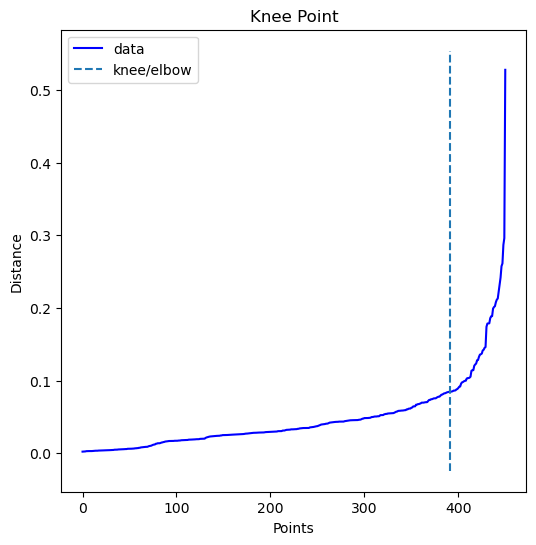

The elbow point is at around 0.085


In [32]:
nearest_neighbors = NearestNeighbors(n_neighbors=7)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 5], axis=0) 

i = np.arange(len(distances))
knee = KneeLocator(
    i, distances, S=1,
    curve='convex',
    direction='increasing',
    interp_method='polynomial'
)
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

EPS = round(distances[knee.knee],3)
print('The elbow point is at around {}'.format(EPS))


In [53]:
dbscan = DBSCAN(eps=0.085)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_DBSCAN'] = vectorizer(dbscan_predictions)

In [49]:
create_map('Cluster_DBSCAN','Colors_DBSCAN','DBSCAN eps={}'.format(EPS))


DBSCAN eps=0.085


In [55]:
print('Number of clusters: {}'
  .format(len(np.unique(dbscan_predictions))))
print('Number of outliers: {}'
  .format(len(dbscan_predictions[dbscan_predictions==-1])))
outliers=[
          (counter+2)*x if x==-1 else x
          for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score without outliers: {}'
  .format(
      silhouette_score(X[dbscan_predictions!=-1],
      dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers: {}'
  .format(silhouette_score(X,outliers)))

Number of clusters: 13
Number of outliers: 31
Silhouette score without outliers: 0.8721990925312116
Silhouette score with outliers: 0.5572768741653514


As we can see, the silhouette score improves considerably without the outliers. Let's proceed to deal with the outliers



In [56]:
scores_no_outlier = []
scores_with_outlier = []
max_score = 0
best_eps = 0
for i in np.arange(0.15, 0, -0.005):
  dbscan = DBSCAN(eps = i)
  dbscan.fit(X)
  dbscan_predictions = dbscan.labels_
  score_without_outlier = silhouette_score(
      X[dbscan_predictions != -1],
      dbscan_predictions[dbscan_predictions != -1]
  )
  scores_no_outlier.append(score_without_outlier)
  outliers = [
              (counter+2)*x if x==-1 else x
              for counter,x in enumerate(dbscan_predictions)
              ]
  scores_with_outlier.append(silhouette_score(X,outliers))
  if score_without_outlier > max_score:
        max_score = score_without_outlier
        best_eps = i

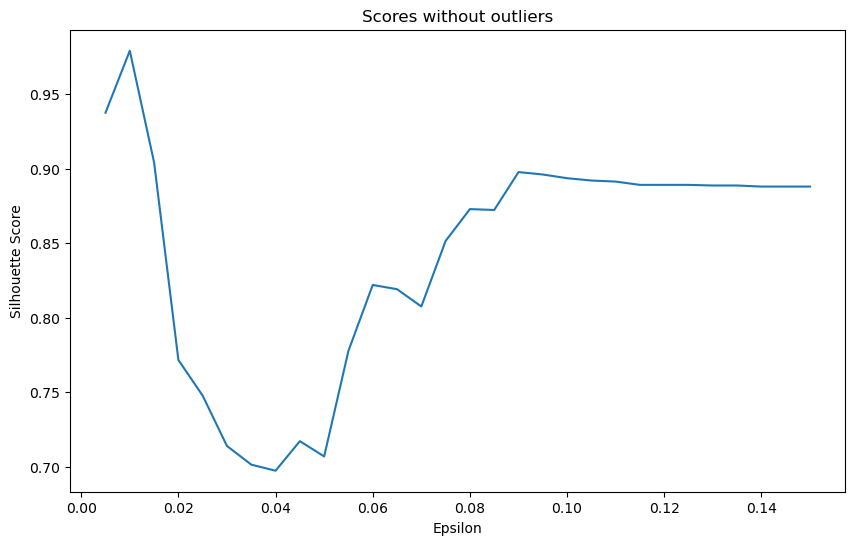

In [57]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0.15,0,-0.005),scores_no_outlier)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Scores without outliers')
plt.show()

In [58]:
print(
    'Highest score = {} obtained for epsilon = {}'
    .format(round(max_score,3),round(best_eps,3))
)

Highest score = 0.979 obtained for epsilon = 0.01


In [59]:
dbscan = DBSCAN(eps=0.01)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN_OPT'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_DBSCAN_OPT'] = vectorizer(dbscan_predictions)

In [60]:
create_map('Cluster_DBSCAN_OPT','Colors_DBSCAN_OPT','DBSCAN OPT')


DBSCAN OPT


In [61]:
print('Number of clusters: {}'
  .format(len(np.unique(dbscan_predictions))))
print('Number of outliers: {}'
  .format(len(dbscan_predictions[dbscan_predictions==-1])))
outliers=[
          (counter+2)*x if x==-1 else x
          for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score without outliers: {}'
  .format(
      silhouette_score(X[dbscan_predictions!=-1],
      dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers: {}'
  .format(silhouette_score(X,outliers)))

Number of clusters: 11
Number of outliers: 349
Silhouette score without outliers: 0.9790035703015864
Silhouette score with outliers: 0.18402688738317732


Conclusions: 

We have used in the first instance a simpleKmeans algorithm to apply, such as Kmeans, which allows us to quickly understand the different clusters that are configured in our dataset.

If we want to make a model obviating the outliers, we can use the DBSCAN as a model, where we will have to determine the epsilon that will be fundamental at the time of making the clusters.

We have shown that DBSCAN works well with geolocation data.


